In [27]:
### FUNCTION DEFINITIONS ###

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import datetime
import pandas as pd
import numpy as np
import scipy.stats as st
import random

class Ticket:
    train_time: int
    thing: int

    def __init__(self, train_time: int, thing: int = 0):
        self.train_time = train_time
        self.thing = thing

    def __eq__(self, other):
        if isinstance(other, Ticket):
            return self.train_time == other.train_time and self.thing == other.thing
        return False

    def __hash__(self):
        return hash(self.train_time, self.thing)
    
class Event:
    event_time: int
    event_kind: str

    def __init__(self, event_time: int, event_kind: str):
        self.event_time = event_time
        self.event_kind = event_kind

    def __lt__(self, other):
        if isinstance(other, Event):
        
            if self.event_time != other.event_time:
                return self.event_time < other.event_time
            
            return self.event_kind < other.event_kind
        return NotImplemented
def grouped_by_month(l: list):
    #returns dict of month -> [changed tickets, tickets total]
    fractions = {}

    for ride in l:
        month = (ride[0].year-2022)*12 + ride[0].month
        if not month in fractions:
            fractions[month] = [0, 0]

        fractions[month][1] += 1

        if ride[2]:
            fractions[month][0] += 1
    return fractions

def get_random_specimen(fraction: float):
    bool_array = [random.random() < fraction for _ in range(0, len(rides))]
    fares_specimen = []
    changes_specimen = []
    for i in range(0, len(rides)):
        if bool_array[i]:
            fares_specimen.append(rides[i][1])
            changes_specimen.append(rides[i][2])
    return (fares_specimen, changes_specimen)

def proportion_by_month(l: list, starting_month: int = 0):
    fractions = grouped_by_month(l)
    result = [0]
    for month in (range(starting_month, max(fractions.keys()))):
        if not month in fractions:
            result.append(result[-1])
            continue
        fraction = fractions[month]
        result.append(fraction[0]/fraction[1])
    return result

def get_data(filename: str, result: list):
    rides_dev = {}
    read_file(filename, rides_dev)

    for key in rides_dev.keys():
        rides_dev[key] = sorted(rides_dev[key])

    split_canceled_tickets(rides_dev)

    format_onto_list(rides_dev, result)

def split_canceled_tickets(storage: dict):
    storage_cpy = list(storage.items())
    for (key, value) in storage_cpy:
        thing_counter = 1
        event_i = 0
        last_event_i = -1
        for v in value:
            if v.event_kind == "Cancel" and event_i != len(value) -1:
                new_key = (key[0], thing_counter)
                storage[new_key] = list(value[last_event_i+1:event_i+1])
                storage[key] = list(value[event_i+1:])
                thing_counter += 1
                last_event_i = event_i
            event_i += 1

def read_file(filename: str, storage: dict):
    with open(filename, 'rt') as file:
            tickets_done = False
            changes_done = False
            i = 1
            lines = file.readlines()
            while i < len(lines):
                line = lines[i]
                if line.startswith("##") and not tickets_done:
                    tickets_done = True
                    i += 1
                elif line.startswith("##") and not changes_done:
                    changes_done = True
                    i += 1
                else:
                    ticket = (int(lines[i+1]), 0)
                    if not tickets_done:
                        if ticket not in storage:
                            storage[ticket] = []

                        storage[ticket].append(Event(int(line), "Bought-Fare " + lines[i+2]))

                        i += 3
                    elif not changes_done:
                        storage[ticket].append(Event(int(line), "Change"))

                        i += 2
                    else:
                        storage[ticket].append(Event(int(line), "Cancel"))

                        i += 2

def format_onto_list(storage: dict, result: list):
    for (key, value) in storage.items():
        if value[-1].event_kind == "Cancel" and key[0] - value[-1].event_time > 2*24*60*60:
            continue

        train_time = key[0]

        is_changed = any(v.event_kind == "Change" for v in value)
        if not value[0].event_kind.startswith("Bought"):
            # this can happen if someone buys a ticket, cancels it and then 
            # buys a ticket from somewhere else, but in the same train and 
            # changes happen. A very rare case... Cant be solved easily though, 
            # because in the "change" email the time specified is from the 
            # "true beginning" station, not from the beginning from the user
            # perspective... 
            continue
        fare = int(value[0].event_kind.split()[1])
        if fare == 0:
            #sometimes they forget to specify it... only like once or twice
            continue

        result.append((datetime.datetime.fromtimestamp(train_time), fare, is_changed))
        
def month_range(date1, date2):
    date_range = pd.date_range(date1, date2)
    date_range = date_range[date_range.day==1]
    return date_range

def standard_deviation(values: list):
    np_values = np.array(values)
    average_sqrd = np.mean(np_values) * np.mean(np_values)
    average_of_sqrd = np.mean(np_values * np_values)
    return np.sqrt(average_of_sqrd - average_sqrd)



In [25]:

rides = []
get_data("stats_V2.txt", rides)
get_data("stats_V3.txt", rides)
rides = list(dict.fromkeys(rides)) # remove duplicates

289
80


# RegioJet a kapitalismus
### Vojtěch Novotný

V této zápočtové práci se podíváme, jestli se chová RegioJet ke člověku stejně nehledě na to, kterou třídou jede. Tato žlutá firma nabízí ve svých vlacích 4 různé tarify, to jest:

    - Low cost
    - STANDARD
    - Relax
    - Economy
Zároveň se poměrně často stává, že člověkovi přijde pár dní/hodin před jízdou tzv. "důležité upozornění", to může být třeba přesazení z low cost vagónu do economy, častěji jsou to ale méně příjemné oznámení, třeba že nepojede klima, nebo že vám dokonce zrušili vagón a jízdenku si můžete zrušit. V této práci se podíváme na to, jestli tarif jízdenky souvisí s tím, jestli člověku přijde takovéto upozornění. 

## Data
Všechna data mám vlastní, regiojet posílá s každou změnou i jízdenkou email, tak se mi povedlo v mém okruhu přátel nastřádat celkem 289 jízdenek, z toho 80 bylo po zakoupení změněno. Jedná se o převážně jízdenky z Havířova do Prahy. Tarify jsou tam z většiny low cost a standard, nezanedbatelné množství relaxů, ale 0 economy (tam nemají ISIC slevy :( ) 

Všechna data musela být rozparsována z textu emailů a tyto maily **neměly** jednotnou formu. Je tedy možné, že se některé maily naparsovaly špatně a já to neměl jak automaticky zkontrolovat. Výsledky této práce by tedy neměly být brány zcela vážně.

Jedna v větších komplikací byla, které zrušené jízdenky do statistiky počítat. Nejjednodušší odpověď je "žádné", problém ale je v tom, že člověk si často jízdenku zruší právě kvůli tomu, že mu přislo upozornění o změně. Druhá nejjednodušší odpověď je "všechny". To by bylo lepší, ale zase když si člověk plánuje jízdy domů na měsíc dopředu a rozmyslí si vlak, co je 3 týdny daleko, měli bychom ho opravdu počítat jako vlak "bez změny"? Nakonec jsem to vyřešil tak, že jsem počítal jen ty zrušené jízdenky, které byly zrušeny méně než 48h před odjezdem, protože do právě toho intervalu 48h spadala **naprostá většina** změn.

Dále v případě, že se našly 2 jízdenky ve stejný čas a se stejným tarifem, počítal jsem je jen jednou, přičemž jsem náhodně vybral kterou. Vynecháním pár ( pár<10 ) náhodných jízdenek nic nepokazíme, na druhou stranu je nechceme započítávat, protože změny se často dějou rovnou celému vagónu, takže by nám to zkreslilo statistiku (a kontrola přímo shody vagónů dvou jízdenek by výrazně zkomplikovala parsování mailů).
## Matematika


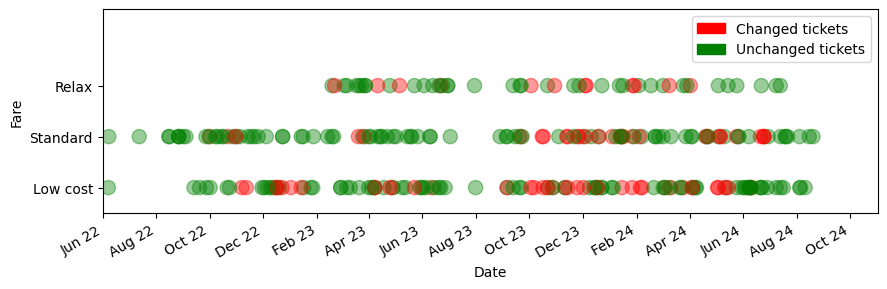

In [35]:
x = [entry[0] for entry in rides]
y = [entry[1] for entry in rides]
color = ["red" if entry[2] else "green" for entry in rides]
red_patch = mpatches.Patch(color='red', label='Changed tickets')
green_patch = mpatches.Patch(color='green', label='Unchanged tickets')

fig, ax = plt.subplots(figsize=(10, 3))
ax.legend(handles=[red_patch, green_patch])

plt.xlabel("Date")
plt.ylabel("Fare")
plt.yticks([1, 2, 3], ["Low cost", "Standard", "Relax"])
plt.ylim(0.5, 4.5)
plt.scatter(x, y, s=105, c=color, alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))  # Format as Year-Month-Day
plt.gcf().autofmt_xdate()

_x = plt.xlim(left=datetime.datetime(2022, 6, 1))
plt.show()


Už "vod voka" jde na grafu vidět, že se dějou 2 věci, což je o 1 více, než jsem předpokládal. Nejen že to vypadá, že má nulová hypotéza by mohla být brzo potvrzena, ale taky to vypadá, že se regiojet s časem docela zhoršil, co se počtu upozornění týče. Podívejme se tedy prvně jestli spolehlivost regiojetu neupadá...

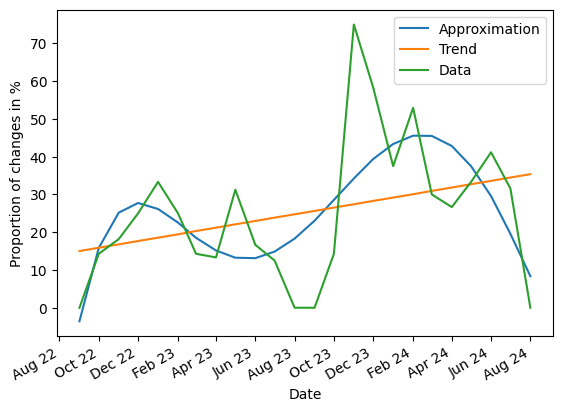

Směrodatná odchylka: 18.61%


In [36]:
starting_month = 9

change_proportions = list(map(lambda x: x * 100, proportion_by_month(rides, starting_month)))

x = range(0, len(change_proportions))
p = np.polyfit(x,change_proportions,5)
poly_y_5 = np.poly1d(p)(x)
p = np.polyfit(x,change_proportions,1)
poly_y_1 = np.poly1d(p)(x)

m_range = month_range(datetime.datetime(2022, starting_month, 1), datetime.datetime(2024, 8, 11)).date

plt.plot(m_range, poly_y_5)
plt.plot(m_range, poly_y_1)
plt.plot(m_range, change_proportions)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Proportion of changes in %')
plt.gca().legend(('Approximation', 'Trend', 'Data'))
plt.show()

print("Směrodatná odchylka: " + str(round(standard_deviation(change_proportions), 2)) + "%")


Ačkoliv to vypadá, že časem se počet změn zvyšuje, při jemněší approximaci jde vidět, že počet změn je velice proměnlivý, pravděpodobně závislý na ročním období (to potvrzuje i směrodatná odchylka). Pro přesnější závěr by to chtělo data z delšího časového úseku. Avšak se musíme vrátit k původní otázce, protože proměnlivost dat může být způsobena i proměnlivostí toho, jaké tarify jsme kdy kupovali!

Mějme tedy nulovou hypotézu "RegioJet se chová se k zákazníkům fér nehledě na zakoupený tarif" a pojďme se ji pokusit vyvrátit. Použijeme k tomu *Pearsonův korelační koeficient* a budeme doufat, že ```p-value``` se dostane pod **0.05** ...

In [302]:
fares = list(map(lambda r: r[1], rides))
changes = list(map(lambda r: 0 if r[2] else 1, rides))

result = st.pearsonr(fares, changes)

print(f"Pearsonův korelační koeficient: {result.statistic}")
print(f"p-value: {result.pvalue}")

Pearsonův korelační koeficient: 0.07743512902840874
p-value: 0.18929624767167286


p-value je daleko nad 0.05 a mé nulové hypotéze tedy musím nadále věřit. RegioJet je skvělá firma a všechny své zákazníky znevýhodňuje *podobně* často. 

Ledaže...

## Čas na p-hacking
První zkusíme experiment opakovat pořád dokola, dokud nám nevyjde hledaná p-value

In [58]:

the_only_pvalue = 1
tries = 0
while(the_only_pvalue > 0.05):
    tries += 1
    fares, changes = get_random_specimen(0.7)

    the_only_pvalue = st.pearsonr(fares, changes).pvalue

print(f"P-value: {the_only_pvalue}")
print(f"Počet pokusů: {tries}")

P-value: 0.036365172823217475
Počet pokusů: 40


To by ale v realitě docela trvalo. Pojďme radši p-hackovat chytřeji. *Nikdo* se nebude zlobit když místo 250 vzorků budu mít 150 a stejně nás přece nejvíce zajímá období, kdy se "Důležité upozornění" *opravdu děly*, pojďme tedy naše vlaky omezit třeba takhle:

In [23]:
fares = list(map(lambda r: r[1], rides))[15:166]
changes = list(map(lambda r: 0 if r[2] else 1, rides))[15:166]

result = st.pearsonr(fares, changes)

print(f"p-value: {result.pvalue}")

p-value: 0.045535730785759225



## Závěr
Tato práce se pokusila dokázat, že RegioJet není fér, avšak se jí to nepovedlo. Slouží tedy hlavně jako varování před pochybnými články, které své závěry vyvozují pouze z pohledu na graf, a před tím, jak snadný je p-hacking.